# Technical note: Sensitivities of a logistic model

In this note we look at a logistic model, defined with initial conditions that depend on model parameters.

## The model

State:
\begin{align}
\frac{dy}{dt} = h y (1 - y)
\end{align}

Initial condition:
\begin{align}
y(t_0, K, h) = \left[1 + \exp(-h(t_0 + K \log 10)) \right]^{-1}
\end{align}

### Case 1: Time starts at 0

In the first case we use
\begin{align}
K &= -4 \\
h &= 1
\end{align}
and set $t_0 = 0$ to get
\begin{align}
y_0(K, h) = \left[1 + \exp(-h K \log 10) \right]^{-1}
\end{align}

We run for 20 time units.

### Case 2: A negative starting time

The second case is based on a drug-modelling example, and uses a negative starting time!

\begin{align}
K &= -4 \\
h &= 1
\end{align}

Now t_0 = -4.605170185988091 and we will run the simulation for $5.1 - t_0$ time units.

## Case 1

Using the syntax defined from Myokit 1.34.0 onwards, we can write:

In [42]:
import myokit

model = myokit.parse_model(
'''
[[model]]
c.y = 1 / (1 + exp(-c.h * c.K * log(10)))

[engine]
time = 0 bind time

[c]
h = 1
K = -4
dot(y) = h * y * (1 - y)
''')

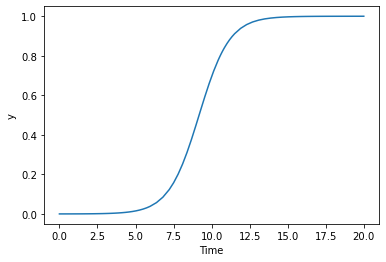

In [43]:
s = myokit.Simulation(model)
d = s.run(20)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.set_ylabel('y')
ax.plot(d.time(), d['c.y'])
plt.show()

### Proposed API

At the moment, we can't do this:

In [38]:
s = myokit.Simulation(model, sensitivities=(['c.y'], ['c.h', 'c.K']))

NotImplementedError: Sensitivities with respect to parameters used in initial conditions is not implemented (1 / (1 + exp(-c.h * c.K * log(10))) depends on c.h).

The reason for this error is that the simulation stores its _state_ and _default state_ as lists of floating point numbers, so no room for fancy expressions!

## Requirements

- The new API should be backwards compatible wherever possible. Users who do not use the new functionality should not have to change their scripts.
- The existing system with a `state`, `default_state` and `reset()`+`pre()` is already slightly confusing to new users. The new system should not be significantly more confusing.
- A good rule of thumb might be that if users aren't thinking about initial conditions they won't notice any changes

Specific methods:
- The methods `sim.state()` and `sim.set_state()` should probably stay working with floats?
- The methods `default_state` and `set_default_state` are less frequently used, and so can maybe be changed a bit?
- The method `reset()` currently resets `state` to the `default_state`, this should be maintained
- The method `pre()` runs a simulation and sets `default_state` to the resulting (numerical) state. This should be maintained
- The method `set_constant()` can be used to change a constant. Should this impact initial states?

## Proposal: The _default state_ uses expressions, the _state_ is floats

The core mechanism was proposed by Martin in https://github.com/myokit/myokit/pull/899.

To handle case 2, we might also want a `set_default_time`.

1. When a simulation is created from a Model
  - Its `initial_state` becomes the model's initial state: a list of expressions
  - Its `state` becomes the evaluation of the initial state: a list of floats
  - Its `initial_s_state` is a matrix of floats with value 1 for $dy/dy_0$ and 0 everywhere else.
  - Its `s_state` is the same.
  - Its `initial_time` is 0

2. Sensitivities
  - Can be defined w.r.t. parameters or w.r.t. initial states.
  - Since initial states can now depend on parameters, we would have to exclude double dependencies, i.e. if an initial state is not a number you can no longer ask for a sensitivity w.r.t. that initial state
  - **Question 1: Alternatively, we could remove the ability to calculate dy/dy0 altogether, only allowing it via y0=f(p). This would make Myokit's language a bit simpler (remove the `init` keyword, remove the `InitialValue` expression that we introduced explicitly for this purpose). Would it make it harder to use though? Or would it make it conceptually more clear? **

3. Getting and setting
  - The `initial_state` can be accessed via `initial_state()` (implementation detail: expressions are immutable) and set with `set_initial_state()`. Both work with expressions (although `set_initial_state` will accept floats for convenience).
  - Methods `state()` and `set_state()` use floats.
    - **Question 2:** Should these methods set the `s_state` too? Or do we maintain separate methods for that?
  - Existing methods `time()` and `set_time()`.
  - We'll add an `initial_time` and `set_initial_time`

4. Running
  - When a simulation is run with `run()` it changes `time`, `state`, `s_state`
  - When a simulation is `reset()` its `time` is set to `initial_time`, its `state` is set to the evaluated `initial_state`, and its `s_state` is set to the `initial_s_state`.

5. Pre-pacing
  - Pre-pacing is meant to bring models closers to a periodic orbit, or closer to a steady state.
  - When a simulation is run with `pre()` it does what `run()` does, but also updates the `initial_state` (with a list of floats!) and `initial_s_state`. 
    - **Question 3:** This means that the *explicit* dependence of `s_state` on initial states is lost. I think this is OK because you wouldn't pre-pace if part of your initial state was a parameter?
    - **Question 4:** It also means that you still have an *implicit* dependence on any initial state parameters from before you pre-paced. That makes less sense to me, because running a simulation now answers the question "how do my states/variables depend on the initial values at some long ago time now forgotten?" I.e. they are no longer the sensitivities w.r.t. the set `initial_state`. Maybe they should all just be zeroed instead? Or should we maintain the "pre paced" sensitivities w.r.t. parameters, but zero the ones for initial states?

6. Using `set_constant` can change parameters in a simulation. For example for fitting. Therefore, it can change the values that an `initial_state` can be evaluated to.
  - **Question 5:** When I (1) Create a sim, (2) Set a parameter, (3) Run. Should I expect the evaluation of the initial_state to have been updated? With the mechanism above the answer would be no (`state` was set to evaluated-`initial_state` at creation). So a user would have to (1) Create a sim, (2) Set a constant, (3) Reset (thereby re-evaluating the initial state), (4) Run?

## Examples

### 1. A simple run

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivities=(['c.y'], ['c.h', 'c.K'])
)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```


### 2. Manually setting the initial_state

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivites=(['c.y'], ['c.h', 'c.K'])
)

sim.set_initial_state([c.h + 5*c.K])

sim.time() --> 0
sim.state() --> A list with 1 float (evaluation of initial state)
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> [c.h + 5*c.K]
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> [c.h + 5*c.K]
sim.initial_s_state() --> A matrix filled with zeroes
```

### 3. Manually setting an s_state and initial_s_state

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivites=(['c.y'], ['c.h', 'c.K'])
)

sim.set_s_state(A matrix filled with numbers)
sim.set_initial_s_state(A matrix filled with numbers)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with numbers
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with numbers

```

### 4. Pre-pacing


```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivities=(['c.y'], ['c.h', 'c.K'])
)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.pre(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 0
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> An updated list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

### 5. Using set_constant

Maybe in the setting of a fit that uses sensitivities, and where we infer the parameter that the sensitivity depends on?
